In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp1d
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

from utils_plot_iso_T3T1 import p_over_pt_from_M, mass_flow_per_area_from_M, M_from_p_over_pt
import os

In [4]:
def read_table(file_path):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
    col_vals = df.iloc[0,1:].values
    row_vals = df.iloc[1:,0].values
    central_vals = df.iloc[1:,1:].values
    return col_vals, row_vals, central_vals

In [ ]:
folder = "compressor_map"

# the beta and the speed are sampled at the same points for mass flow, pressure ratios, and iso-efficiencies
beta_comp, speed_comp, mf_comp = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, pr_comp = read_table(f"{folder}/formatted_iso_pressure_ratio.txt")
_, _, eff_comp = read_table(f"{folder}/formatted_iso_efficiency.txt")

surge_df = pd.read_csv(f"{folder}/formatted_surge_line.txt", delim_whitespace=True, header=None)

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\575458391.py:8: FutureWarning: The 'delim_whitespace' keyword i

# Compressor map processing

In [ ]:
# -----------------------------
# Flatten arrays for interpolation
# -----------------------------
n_rows, n_cols = len(speed_comp), mf_comp.shape[1]

# Matrices:
mf_flat_comp = mf_comp.flatten()
eff_flat_comp = eff_comp.flatten()
pr_flat_comp = pr_comp.flatten()

# Vector:
speed_flat_comp = np.repeat(speed_comp, n_cols)   # repeat speed along columns

num_steps = 100

mf_grid_comp, pr_grid_comp = np.meshgrid(
    np.linspace(mf_flat_comp.min(), mf_flat_comp.max(), num_steps),
    np.linspace(pr_flat_comp.min(), pr_flat_comp.max(), num_steps)
)


# -----------------------------
# Interpolation on grid
# -----------------------------
eff_grid_comp = griddata((mf_flat_comp, pr_flat_comp), eff_flat_comp, (mf_grid_comp, pr_grid_comp), method='cubic')
speed_grid_comp = griddata((mf_flat_comp, pr_flat_comp), speed_flat_comp, (mf_grid_comp, pr_grid_comp), method='cubic')

# -----------------------------
# Surge line mask
# -----------------------------
surge_vals = surge_df.values.flatten()
n = len(surge_vals)//2
surge_X, surge_Y = surge_vals[:n], surge_vals[n:]
surge_interp = interp1d(surge_X, surge_Y, bounds_error=False, fill_value="extrapolate")
Y_grid_surge = surge_interp(mf_grid_comp[0,:])
Y_grid_mask = pr_grid_comp <= Y_grid_surge[np.newaxis, :]   # broadcast mask

# Apply mask
eff_grid_mask_comp = np.where(Y_grid_mask, eff_grid_comp, np.nan)
speed_grid_mask_comp = np.where(Y_grid_mask, speed_grid_comp, np.nan)

Now we want to prepare the 2 matrices and the two vector for interfacing the compressor and the turbnozz maps.

In [107]:
print(f"mf_comp: {mf_comp.shape}, mf_grid_comp shape: {mf_grid_comp.shape}")
print(f"pr_comp: {pr_comp.shape}, pr_grid_comp shape: {pr_grid_comp.shape}")
print(f"speed_comp: {speed_comp.shape}, speed_grid_mask_comp shape: {speed_grid_mask_comp.shape}")
print(f"eff_comp: {eff_comp.shape}, eff_grid_mask_comp shape: {eff_grid_mask_comp.shape}")

mf_comp: (14, 9), mf_grid_comp shape: (100, 100)
pr_comp: (14, 9), pr_grid_comp shape: (100, 100)
speed_comp: (14,), speed_grid_mask_comp shape: (100, 100)
eff_comp: (14, 9), eff_grid_mask_comp shape: (100, 100)


In [81]:
mf_grid_comp_opt = np.zeros((len(speed_comp), num_steps), dtype = np.float64)
pr_grid_comp_opt = np.zeros((len(speed_comp), num_steps), dtype  = np.float64)
eff_grid_comp_opt = np.zeros((len(speed_comp), num_steps), dtype = np.float64)

N_comp_levels = np.linspace(speed_comp.min(), speed_comp.max(), len(speed_comp))


for i, N in enumerate(N_comp_levels):
    mf_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), mf_grid_comp, np.nan)
    pr_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), pr_grid_comp, np.nan)
    eff_grid_comp_N = np.where(np.isclose(speed_grid_mask_comp, N, atol = 1e-2, rtol = 1e-5), eff_grid_comp, np.nan)

    mask_valid = ~np.isnan(pr_grid_comp_N)
    mf_vals_comp_N = mf_grid_comp_N[mask_valid]
    pr_vals_comp_N = pr_grid_comp_N[mask_valid]
    eff_vals_comp_N = eff_grid_comp_N[mask_valid]

    sort_idx = np.argsort(pr_vals_comp_N) 
    pr_sorted = pr_vals_comp_N[sort_idx]
    mf_sorted = mf_vals_comp_N[sort_idx]
    eff_sorted = eff_vals_comp_N[sort_idx]

    pr_sorted, unique_idx = np.unique(pr_sorted, return_index=True)
    mf_sorted = mf_sorted[unique_idx]
    eff_sorted = eff_vals_comp_N[unique_idx]

    pr_uniform = np.linspace(pr_sorted.min(), pr_sorted.max(), num_steps)
  
    mf_interp = interp1d(pr_sorted, mf_sorted, kind='linear', fill_value="extrapolate")
    eff_interp = interp1d(pr_sorted, eff_sorted, kind='linear', fill_value="extrapolate")
    
    x_data = pr_uniform
    y_data = mf_interp(pr_uniform)
    z_data = eff_interp(pr_uniform)
    
    degree = 2
    coeffs_mf = np.polyfit(x_data, y_data, degree)
    coeffs_eff = np.polyfit(x_data, z_data, degree)

    mf_grid_comp_opt[i,:] = np.polyval(coeffs_mf, x_data)
    eff_grid_comp_opt[i, :] = np.polyval(coeffs_eff, x_data)

    pr_grid_comp_opt[i,:] = pr_uniform

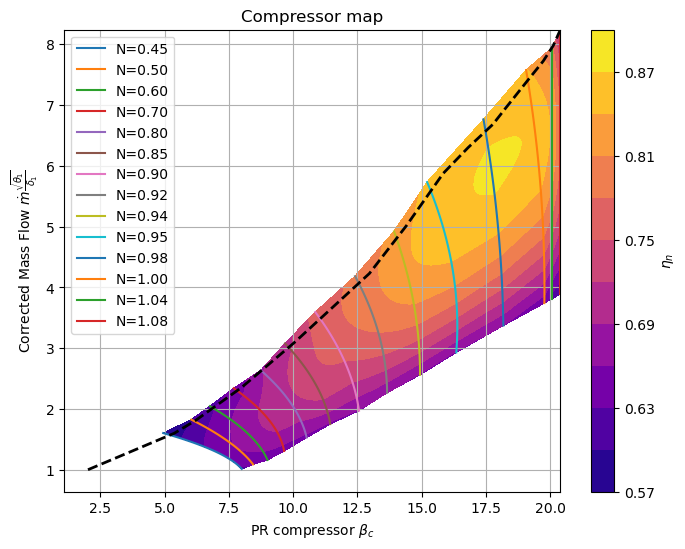

In [104]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # 1 row, 2 columns
for i, N in enumerate(speed_comp):
    axes.plot(mf_grid_comp_opt[i,:], pr_grid_comp_opt[i,:], label=f"N={N:.2f}")

axes.legend()
axes.plot(surge_X, surge_Y, 'k--', linewidth=2, label='Surge Line')

cont_n = axes.contourf(mf_grid_comp_opt, pr_grid_comp_opt, eff_grid_comp_opt, levels=10, cmap = 'plasma')
cbar1 = fig.colorbar(cont_n , ax=axes, label= r'$\eta_n$')
axes.set_xlabel(r'PR compressor $\beta_c$')
axes.set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_1}}{\delta_1}$')
axes.set_title(r'Compressor map')
axes.grid()
    

In [109]:
print(f"N_comp_levels shape: {N_comp_levels.shape}")
print(f"mf_grid_comp_opt shape: {mf_grid_comp_opt.shape}")
print(f"pr_grid_comp_opt shape: {pr_grid_comp_opt.shape}")
print(f"eff_grid_mask_comp_opt shape: {eff_grid_comp_opt.shape}")

N_comp_levels shape: (14,)
mf_grid_comp_opt shape: (14, 100)
pr_grid_comp_opt shape: (14, 100)
eff_grid_mask_comp_opt shape: (14, 100)


# Turbine map processing

In [83]:
folder = "turbine_map"

# -----------------------------
# Read turbine mass flow
# -----------------------------
beta_turb, speed_turb, mf_turb = read_table(f"{folder}/formatted_mass_flow.txt")
_, _, eff_turb = read_table(f"{folder}/formatted_iso_efficiency.txt")

#####################################################################################à

# Pressure ratio mapping (simple linear scaling, see cell below)    
pr_turb_min, pr_turb_max = 0.01, 3.8
pr_turb = np.linspace(pr_turb_min, pr_turb_max, len(beta_turb))

pr_dense_turb = np.linspace(pr_turb_min, pr_turb_max, num_steps)
pr_grid_turb_opt = np.tile(pr_dense_turb, (len(speed_turb), 1))                                                 

mf_grid_turb_opt = np.zeros_like(pr_grid_turb_opt)
eff_grid_turb_opt = np.zeros_like(pr_grid_turb_opt)

for i, isoN in enumerate(speed_turb):
    mf_isoN = mf_turb[i, :]
    mf_interpolator_turb = interp1d(pr_turb, mf_turb[i, :], kind = 'cubic')
    mf_grid_turb_opt[i, :] = mf_interpolator_turb(pr_dense_turb)

    eff = eff_turb[i, :]
    eff_interpolator_turb = interp1d(pr_turb, eff_turb[i, :], kind = 'cubic')
    eff_grid_turb_opt[i, :] = eff_interpolator_turb(pr_dense_turb)

C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style
C:\Users\Lenovo1\AppData\Local\Temp\ipykernel_23148\4030266264.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path, delim_whitespace=True, header=None)  # keep old style


In [129]:
print(f"N_turb_levels shape: {speed_turb.shape}")
print(f"mf_grid_turb_opt shape: {mf_grid_turb_opt.shape}")
print(f"pr_grid_turb_opt shape: {pr_grid_turb_opt.shape}")
print(f"speed_grid_mask_turb_opt shape: {eff_grid_turb_opt.shape}")

N_turb_levels shape: (9,)
mf_grid_turb_opt shape: (9, 100)
pr_grid_turb_opt shape: (9, 100)
speed_grid_mask_turb_opt shape: (9, 100)


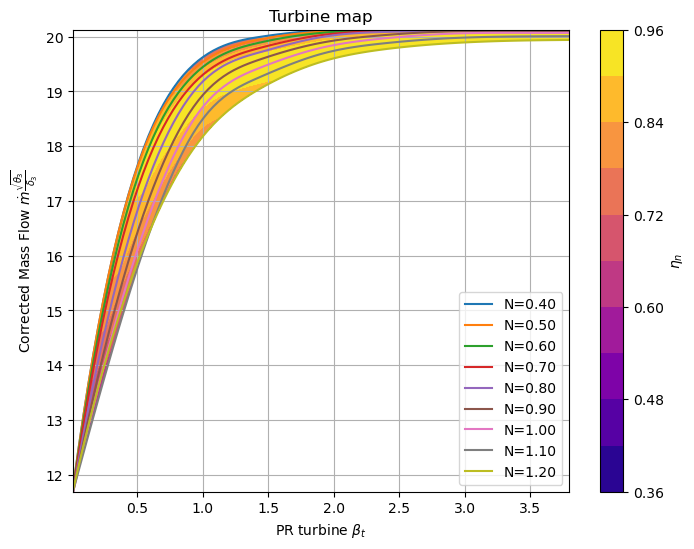

In [117]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # 1 row, 2 columns
for i, N in enumerate(speed_turb):
    axes.plot(pr_grid_turb_opt[i,:], mf_grid_turb_opt[i,:], label=f"N={N:.2f}")

axes.legend()

cont_n = axes.contourf(pr_grid_turb_opt, mf_grid_turb_opt, eff_grid_turb_opt, levels=10, cmap = 'plasma')
cbar1 = fig.colorbar(cont_n , ax=axes, label= r'$\eta_n$')
axes.set_xlabel(r'PR turbine $\beta_t$')
axes.set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$')
axes.set_title(r'Turbine map')
axes.grid()

# Nozzle map

In [118]:
# ============================================================
# NOZZLE DATA
# ============================================================
A_out = 0.3 ** 2 * np.pi     # [m^2]
A_in = 0.45 ** 2 * np.pi

gamma = 1.33    # [-]
R = 287.0      # [J / kg / K]
p_amb = 101325 # [Pa]

# Tt1 = T_amb
# Tt2 = Tt1 * ( 1 + (beta_comp ** ((gamma - 1) / (gamma)) - 1) / eta_comp)
# Tt3 = calculate_T3_tot(Tt2, alpha = alpha0, max_iter = 5, tol = 1e-4)
# Tt4 = Tt3 * ( 1 - eta_turb * ( 1 - PR_turb ** (- (gamma - 1)/(gamma)) ) )
Tt4 = 800 # It actually cancels out in the mass flow correction, so you can also fix a random value

T_ref = 288

p_over_pt_crit = p_over_pt_from_M(1, gamma)
pr_crit_nozz = 1.0 / p_over_pt_crit

pr_nozz = np.append(np.linspace(1.0, pr_crit_nozz, int(num_steps / (10 / 8))), np.linspace(pr_crit_nozz-0.00001, 5, int(num_steps / (10 / 2))))
pt_vals = pr_nozz * p_amb
mf_nozz = np.zeros_like(pr_nozz)

for i, pt_i in enumerate(pt_vals):
    p_ratio = p_amb / pt_i
    if p_ratio < p_over_pt_crit: # Careful! It's p_over_pt ~ 0.5 not pt_over_p ~ 1.85 
        M_exit = 1.0
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_exit, gamma, R)
        mf_nozz[i] = A_out * mass_flow_area * np.sqrt(Tt4/T_ref) / (pt_i / p_amb)
    else:
        
        M_root = M_from_p_over_pt(p_ratio, gamma)
        mass_flow_area, _ = mass_flow_per_area_from_M(pt_i, Tt4, M_root, gamma, R)
        mf_nozz[i] = A_out * mass_flow_area *  np.sqrt(Tt4/T_ref) / (pt_i / p_amb)

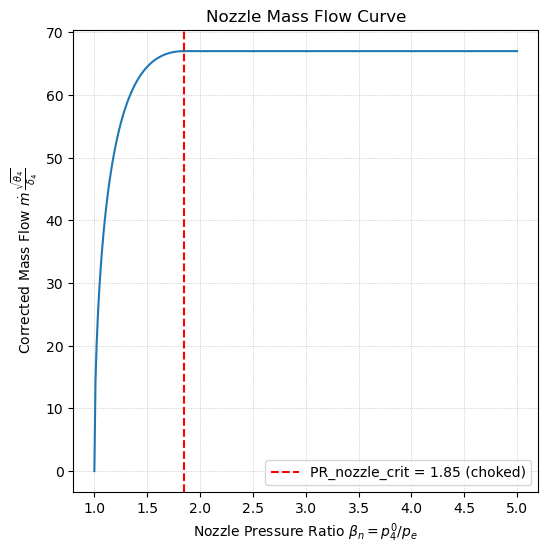

In [119]:
fig, axes = plt.subplots(1, 1, figsize=(6,6))

# --- Nozzle Curve ---
axes.plot(pr_nozz, mf_nozz, color='tab:blue')
axes.axvline(pr_crit_nozz, linestyle='--', color='red',
                label=f'PR_nozzle_crit = {pr_crit_nozz:.2f} (choked)')
axes.set_xlabel(r'Nozzle Pressure Ratio $\beta_n = p_4^0 / p_e$')
axes.set_ylabel(r'Corrected Mass Flow $\dot{m} \, \frac{\sqrt{\theta_4}}{\delta_4}$')
axes.set_title('Nozzle Mass Flow Curve')
axes.grid(True, linestyle=':', linewidth=0.5)
axes.legend()

# Turbnozz map

In [139]:
mf_crit_nozz = mf_nozz[-1]

pr_grid_turbnozz = np.zeros_like(mf_grid_turb_opt)
mf_grid_turbnozz = np.zeros_like(mf_grid_turb_opt)
eff_grid_turbnozz = np.zeros_like(eff_grid_turb_opt)
speed_turbnozz = speed_turb


for i, PRt in enumerate(pr_dense_turb):
    for j, Nt in enumerate(speed_turbnozz):

        # Set a point on the Turbine map (PRt and Nt are already selected by the for cycles):
        mf_match_turb = mf_grid_turb_opt[j, i] # the correct indexing is mf_match_turb[PR_idx, N_idx]
        eta_match_turb = eff_grid_turb_opt[j, i]

        # Calculate the corrected mass flow that would go through the nozzle
        mf_match_nozzle = mf_match_turb * PRt * np.sqrt(( 1 - eta_match_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )

        if mf_match_nozzle <= mf_crit_nozz:
            # then the selected point is fine, the turbine is not blocked

            # The overall PR is the product between the two
            idx_PRn = np.abs(mf_nozz - mf_match_nozzle).argmin()
            pr_grid_turbnozz[j, i] = PRt * pr_nozz[idx_PRn]

            # The mass flowing is corrected  with pre-turbine params
            mf_grid_turbnozz[j, i] = mf_match_turb

        elif np.isclose(mf_match_nozzle, mf_crit_nozz, rtol = 0.05, atol = 2): 
            # The nozzle is choked, the turbine is blocked: the maximum mass flow is the one allowed by the nozzle, corrected with pre-turbine quantities by convention
            mf_grid_turbnozz[j, i] = mf_crit_nozz / PRt / np.sqrt(( 1 - eta_match_turb * ( 1 - PRt ** ( - (gamma - 1)/(gamma) ) ) ) )

            # Now the Nozzle has an increase in PR without letting more mass to flow
            idx_PRn = np.abs(mf_nozz - mf_match_nozzle).argmin() 
            pr_grid_turbnozz[j, i] = PRt * pr_nozz[idx_PRn]
        
        else:
            mf_grid_turbnozz[j, i] = np.nan
            pr_grid_turbnozz[j, i] = np.nan

In [138]:
print(f"speed_turbnozz shape: {speed_turbnozz.shape}")
print(f"mf_grid_turbnozz shape: {mf_grid_turbnozz.shape}")
print(f"pr_grid_turbnozz shape: {pr_grid_turbnozz.shape}")
print(f"eff_grid_turbnozz shape: {eff_grid_turb_opt.shape}")

speed_turbnozz shape: (9,)
mf_grid_turbnozz shape: (9, 100)
pr_grid_turbnozz shape: (9, 100)
eff_grid_turbnozz shape: (9, 100)


In [140]:
fig, ax = plt.subplots(figsize=(14, 6))

# two lines (turbine+nozzle and turbine-only)
line1, = ax.plot([], [], lw=2, label='Turbine + Nozzle')
line2, = ax.plot([], [], lw=2, linestyle='--', label='Turbine')

ax.set_xlabel(r"PR turbine + nozzle $\beta_t \beta_n$")
ax.set_ylabel(r"Corrected Mass Flow $\dot m \frac{\sqrt{\theta_3}}{\delta_3}$")
ax.legend()

# determine axis limits from your data (robust to NaNs)
xmin = np.nanmin([np.nanmin(pr_grid_turbnozz), np.nanmin(pr_grid_turb_opt)])
xmax = np.nanmax([np.nanmax(pr_grid_turbnozz), np.nanmax(pr_grid_turb_opt)])
ymin = np.nanmin([np.nanmin(mf_grid_turbnozz), np.nanmin(mf_grid_turb_opt)])
ymax = np.nanmax([np.nanmax(mf_grid_turbnozz), np.nanmax(mf_grid_turb_opt)])
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

def update(i):
    # i is the idx_plot (0..len(speed_turb)-1)
    plt.grid()
    line1.set_data(pr_grid_turbnozz[i, :], mf_grid_turbnozz[i, :])
    line2.set_data(pr_grid_turb_opt[i, :], mf_grid_turb_opt[i, :])
    ax.set_title(f"Comparison between iso-N lines, N_corr={speed_turb[i]:.2f}  ({i+1}/{len(speed_turb)})")
    return line1, line2

ani = FuncAnimation(fig, update, frames=range(len(speed_turb)),
                    init_func=init, blit=False, interval=800, repeat=True)

# Try to embed as JS first (works well in classic Jupyter Notebook)
try:
    js = ani.to_jshtml()
    plt.close(fig)   # avoid double-render
    display(HTML(js))
except Exception:
    # fallback to HTML5 video (may require ffmpeg)
    try:
        vid = ani.to_html5_video()
        plt.close(fig)
        display(HTML(vid))
    except Exception:
        # last resort: show first frame and raise a helpful message
        print("Could not create embedded animation (to_jshtml/to_html5_video failed). Showing the first frame instead.")
        update(0)
        plt.show()

## Turbnozz + Compressor Matching

1. Take a point on the compressor map and retrieve the associated values of corrected speed `N_corr` and compressor efficiency `η_c`.  
2. Assume a trial value for the temperature ratio `T3/T1`.  
3. Use this assumed `T3/T1` to retrieve a point on the turbine map, applying the congruence equations (mass and rpm conservations).  
4. Check the pressure congruence between compressor outlet and turbine inlet/outlet.  
5. Iterate adjusting `T3/T1` until pressure congruence is satisfied.


In [133]:
# Constants definition

epsilon_b = 0.99 # [-] Combustor pressure ratio TODO: implement combustor map

epislon_d = 0.99 # [-] Air intake pressure ratio TODO: implement air intake map

M0 = 0.5 # [-] Assumed aircraft Mach number (actually is an input from the game)

gamma = 1.4 # [-] Air specific heat ratio cp/cv

In [ ]:
# Compressor map pre-processing

indices_comp = ~np.isnan(mf_grid_comp_opt)
indices_comp = list(zip(*np.where(indices_comp)))

# Pre-allocation of the output parameters
best_temp_ratios = np.full(mf_grid_comp_opt.shape, np.nan)
best_differences = np.full(mf_grid_comp_opt.shape, np.nan)

total_points = len(indices_comp)

differences = []
temp_ratios_list = []

# Turbnozz map pre-processing 
mf_flat_turbnozz = mf_grid_turbnozz.flatten()
pr_flat_turbnozz = pr_grid_turbnozz.flatten()
eff_flat_turbnozz = eff_grid_turbnozz.flatten()

for count, (i, j) in tqdm(enumerate(indices_comp, start=1), desc = "Processing", ncols = len(speed_comp), nrows = num_steps, leave = True): # i = Compressor N_corr, j = Compressor PR
# for count, (i, j) in enumerate(valid_indices[500:600], start=1):

    # print(f"Processing point {count}/{total_points} -> index (i={i}, j={j})")

    differences = []
    temp_ratios_list = []
    for temp_ratio in np.arange(0.9, 3.9, 0.05):

        # mf and N set by the compressor but corrected with turbine params:
        mf_cons_turbnozz = mf_grid_comp_opt[i, j] / pr_grid_comp_opt[i, j] / epsilon_b * np.sqrt(temp_ratio)
        N_cons_turbnozz =  speed_comp[i]  / np.sqrt(temp_ratio)


        # now we have to find where these mf and N are on the turbine map
        idx_min_N = np.nanargmin(np.abs(N_cons_turbnozz - speed_turbnozz)) # u
        idx_min_mf = np.nanargmin(np.abs(mf_grid_turbnozz[idx_min_N, :] - mf_cons_turbnozz)) # v

        # Calculate RHS and LHS of the pressure congruence equation
        LHS_pressure_eq = (1 + (gamma - 1) / 2 * M0 ** 2) ** (gamma / (gamma - 1)) * epislon_d * pr_grid_comp_opt[i, j]
        RHS_pressure_eq =  pr_grid_turbnozz[idx_min_N, idx_min_mf] / epsilon_b

        temp_ratios_list.append(temp_ratio)
        differences.append(abs(LHS_pressure_eq - RHS_pressure_eq))

    # Salva il temp_ratio con differenza minima
    idx_best_temp_ratio = np.argmin(differences)
    best_temp_ratios[i, j] = temp_ratios_list[idx_best_temp_ratio]
    best_differences[i, j] = differences[idx_best_temp_ratio] # store the difference between LHS and RHS to eventually add constraint on the tolerance 

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Processing: 459it [00:01, 333.06it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Processing: 1316it [00:04, 304.22it/s]


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


Processing: 1400it [00:04, 311.38it/s]

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


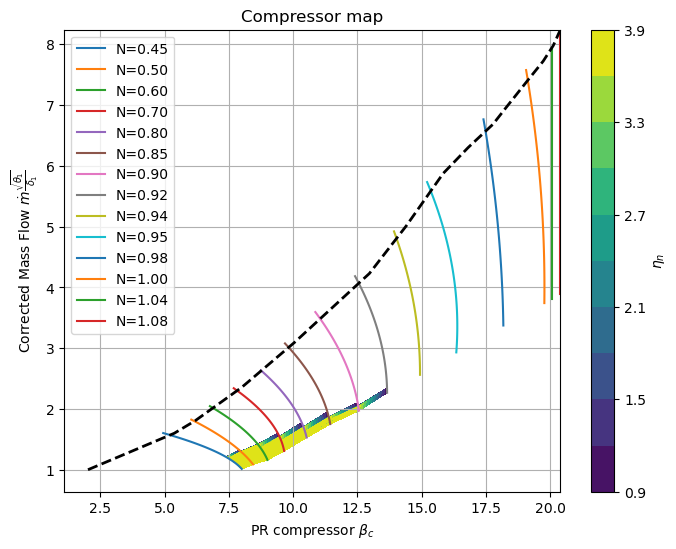

In [157]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))  # 1 row, 2 columns
for i, N in enumerate(speed_comp):
    axes.plot(mf_grid_comp_opt[i,:], pr_grid_comp_opt[i,:], label=f"N={N:.2f}")

cont_T = axes.contourf(mf_grid_comp_opt, pr_grid_comp_opt, best_temp_ratios, levels=10, cmap = 'viridis')
cbar1 = fig.colorbar(cont_T , ax=axes, label= r'$\eta_n$')


axes.legend()
axes.plot(surge_X, surge_Y, 'k--', linewidth=2, label='Surge Line')

# cont_n = axes.contourf(mf_grid_comp_opt, pr_grid_comp_opt, eff_grid_comp_opt, levels=10, cmap = 'plasma')
# cbar2 = fig.colorbar(cont_n , ax=axes, label= r'$\eta_n$')
axes.set_xlabel(r'PR compressor $\beta_c$')
axes.set_ylabel(r'Corrected Mass Flow $\dot m \frac{\sqrt{\theta_1}}{\delta_1}$')
axes.set_title(r'Compressor map')
axes.grid()
    